In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random

In [2]:
##------------------------------Pegando os Dados-----------------------------------

#url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-12-21/2019-03-21/A307"
url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2019-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    df.dropna(inplace=True)
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1

<ipython-input-2-4c0a7404db43>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1


In [3]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino):
    valorMediaTemp = df_training_temp_anomalie_edit['TEMP_MAX'].sum()/df_training_temp_anomalie_edit.shape[0]
    desvioPadraoTemp = df_training_temp_anomalie_edit["TEMP_MAX"].std()
    if treino:
        desvioPadraoTempTraining = desvioPadraoTemp
    else:
        desvioPadraoTempTest = desvioPadraoTemp
    desvioPadraoEditadoTemp = 3 * desvioPadraoTemp
    valorFinalTemp = desvioPadraoEditadoTemp + valorMediaTemp
    #valorFinalTemp = equacaoExponencial()
    valorFinalTemp = equacaoExponencial() * extrairErro(df_training_temp_anomalie_edit)
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino):
    valorMediaUmid = df_training_temp_anomalie_edit['UMID_MED'].sum()/df_training_temp_anomalie_edit.shape[0]
    desvioPadraoUmid = df_training_temp_anomalie_edit["UMID_MED"].std()
    if treino:
        desvioPadraoUmidTraining = desvioPadraoUmid
    else:
        desvioPadraoUmidTest = desvioPadraoUmid
    desvioPadraoEditadoUmid = 3 * desvioPadraoUmid
    valorFinalUmid = desvioPadraoEditadoUmid + valorMediaUmid
    #valorFinalUmid = equacaoExponencial()
    valorFinalUmid = equacaoExponencial() * extrairErro(df_training_temp_anomalie_edit)
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def extrairErro(dataframe):
    train_size = int(dataframe.shape[0] * 1)
    train = dataframe[1:train_size]
    train_X, train_y = train.to_numpy()[:,0], train.to_numpy()[:,1]
    train_pred = [x for x in train_X]
    train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
    desvio = np.std(train_resid)
    return desvio

def TransformarEmEstacionaria(df_training_temp):
    df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
    df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
        
    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

In [106]:
#------------------------------Tratando os Dados-----------------------------------

def dataTraining(percentOutliers, dbscan):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    if dbscan:
        qtd_training_temp = qtdRowsTemp()
    
    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp)
    
    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)
    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)

    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].astype(float)

    valorFinalTemp = valorFinalTemperatura(df_training_temp_anomalie_edit, True)
    valorFinalUmid = valorFinalUmidade(df_training_temp_anomalie_edit, True)
    
    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_training_temp_anomalie_edit.sort_index(inplace=True)
    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit])

    print (df_training_temp_anomalie_edit)
    
    #Treino
    df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
    df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)
    df_training_temp = df_training_temp.drop(columns='id')
    
    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(n=count_test_temp, random_state=1)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].astype(float)
    
    valorFinalTemp = valorFinalTemperatura(df_test_temp_anomalie_edit, False)
    valorFinalUmid = valorFinalUmidade(df_test_temp_anomalie_edit, False)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    df_test_temp.sort_index(inplace=True)

    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp

In [107]:
#import random

taxaContaminacao = 2
dfs = dataTraining(taxaContaminacao, True)
df_training_temp = dfs[0]
df_test_temp = dfs[1]

print (df_training_temp)

      TEMP_MAX   UMID_MED   id
235   4.768257  33.163977  236
292   9.768257  18.063977  293
347   5.368257  23.663977  348
388   5.368257  38.963977  389
528   4.168257  53.963977  529
564   3.168257  41.963977  565
567   1.868257  37.563977  568
571   8.368257  17.763977  572
587   8.068257  35.263977  588
626  10.068257  28.563977  627
649   4.168257  42.563977  650
721   8.068257  30.163977  722
     TEMP_MAX  UMID_MED
0         1.2      -7.5
1         3.3     -10.4
2         2.7      -8.1
3        -1.8      20.6
4        -3.0      20.4
..        ...       ...
725       1.2      -0.5
726      -2.9       4.2
727       3.8      -1.0
728       5.2     -12.2
729      -6.8      32.2

[611 rows x 2 columns]


In [44]:
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

def AutoRegValue(df_training_temp):   
    df_stationarityTest = adfuller(df_training_temp['TEMP_MAX'], autolag='AIC')
    #pacf = plot_pacf(df_training_temp['TEMP_MAX'], lags=1)
    train_data = df_training_temp['TEMP_MAX'][:len(df_training_temp)]
    #test_data = df_training_temp['TEMP_MAX'][len(df_training_temp)-100:]
    ar_model = AutoReg(train_data, lags=1, trend = 'n').fit()
    return ar_model.bse


14.552377531674816



Outliers encontrados: 
(11, 2)
      TEMP_MAX   UMID_MED
228   0.400000 -31.000000
292   9.768257  18.063977
313   9.400000 -36.300000
347   5.368257  23.663977
349  -3.900000 -20.400000
528   4.168257  53.963977
567   1.868257  37.563977
571   8.368257  17.763977
587   8.068257  35.263977
626  10.068257  28.563977
721   8.068257  30.163977


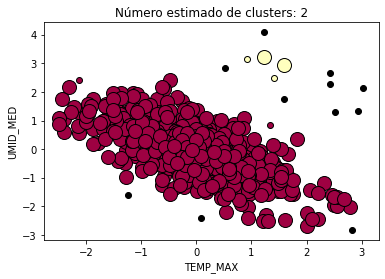

In [118]:
#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan_part1(df, eps, min_samples):
    #X = np.array([ [1, 2], [2, 2], [7, 6], [28, 7], [2, 3], [25, 8], [3, 2],[1, 3],[1.1, 2],[1.2, 2],[1.3, 2],[1.4, 2]])
    X = np.array(df)
    X = StandardScaler().fit_transform(df)
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='brute',p=100).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    print ()
    print('Outliers encontrados: ')
    print (outliers.shape)
    print (outliers)

    plt.title('Número estimado de clusters: %d' % n_clusters_)
    plt.xlabel("TEMP_MAX")
    plt.ylabel("UMID_MED")
    plt.show()

eps = 0.5
min_samples = 3
#print (df_training_temp.shape)
#print (df_training_temp)

#x = np.array([[10, 50], [12, 50], [48, 70]], np.float)

#df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
#df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)
#df_training_temp = np.array([[10, 20], [12, 21], [10, 23], [57,75]], np.float)

dbscan_part1(df_training_temp, eps, min_samples)


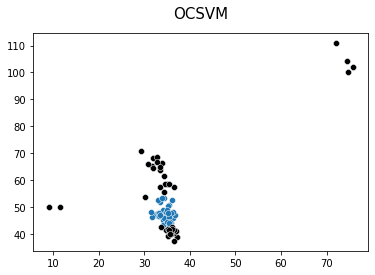

In [19]:
from sklearn.svm import OneClassSVM
import seaborn as sns

x = np.array([[10, 50], [12, 50]], np.float)
df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)


X = np.array(df_training_temp)
X, _ = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)

ocsvm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.5, coef0=0.0,tol=0.001,
                    shrinking=True,cache_size=10,
                    verbose=False,max_iter=-1).fit(X)
pred = ocsvm.predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='black')
plt.title("OCSVM", fontsize=15, pad=15)
plt.savefig("One-Class SVM Detection.png", dpi=80)

Text(0, 0.5, 'UMID_MED')

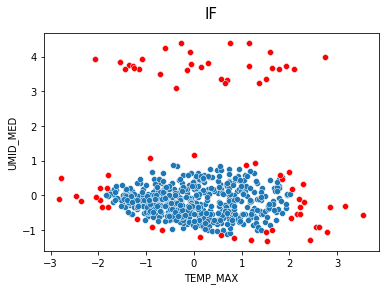

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns

x = np.array([[10, 50], [12, 50]], np.float)
df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)

X = np.array(df_training_temp)

iforest = IsolationForest(n_estimators=300, max_samples=df_training_temp.shape[0], 
                          warm_start=False,
                          contamination='auto', max_features=1.0, 
                          bootstrap=False, n_jobs=None, random_state=None)

pred = iforest.fit_predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sc=StandardScaler()
X_scaled = sc.fit_transform(X)
outlier_values_scaled = sc.transform(outlier_values)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outlier_values_pca = pca.transform(outlier_values_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("IF", fontsize=15, pad=15)
plt.xlabel("TEMP_MAX")
plt.ylabel("UMID_MED")

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

X_test = np.array(df_test_temp)
X_train = np.array(df_training_temp)

# fit the model
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma='scale').fit(X_train)
y_pred_train = clf.predict(X_train)
print (y_pred_train)
print ()
y_pred_test = clf.predict(X_test)
print (y_pred_test)

'''
outlier_index = np.where(y_pred_train==-1)
outlier_values = X_train[outlier_index]
print (outlier_values)
'''


[ 1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1
 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1
  1 -1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1  1
 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1
  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1
  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1
 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1
  1 -1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1

'\noutlier_index = np.where(y_pred_train==-1)\noutlier_values = X_train[outlier_index]\nprint (outlier_values)\n'